In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
plt.rcParams["lines.linewidth"] = 4
plt.rcParams["lines.markersize"] = 10
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'

# Regression with uncertainty

Two kinds of regression model that give you a best fit line as well as an estimate of the "noise level" at each point.

This notebook looks at gaussian processes and quantile regression with gradient boosted trees.

We first setup a toy problem. In this case we will try and fit a model to a simple function like $\sin((x-2.5)^2)$. We assume that we know nothing about this function. If we had an idea about the analytic function we could certainly do better than this by using that information.

The first part generates a small number (ten) of observations from the unknown function that we will use to fit our models. To make the problem harder the observations are noisy.

In [2]:
noise_level = 0.3

def f(x, noise_level=noise_level):
    return np.sin((x[0] - 2.5) ** 2) + np.random.randn() * noise_level


# for plotting purposes also evaluate the function without noise
x = np.linspace(0, 5, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]

In [3]:
# ten random points at which we observe our unknown function
rng = np.random.RandomState(3)
X = rng.uniform(0, 5, 10)
X = X.reshape(-1, 1)

y = np.array([f(x_i) for x_i in X])
y = y.reshape(-1)

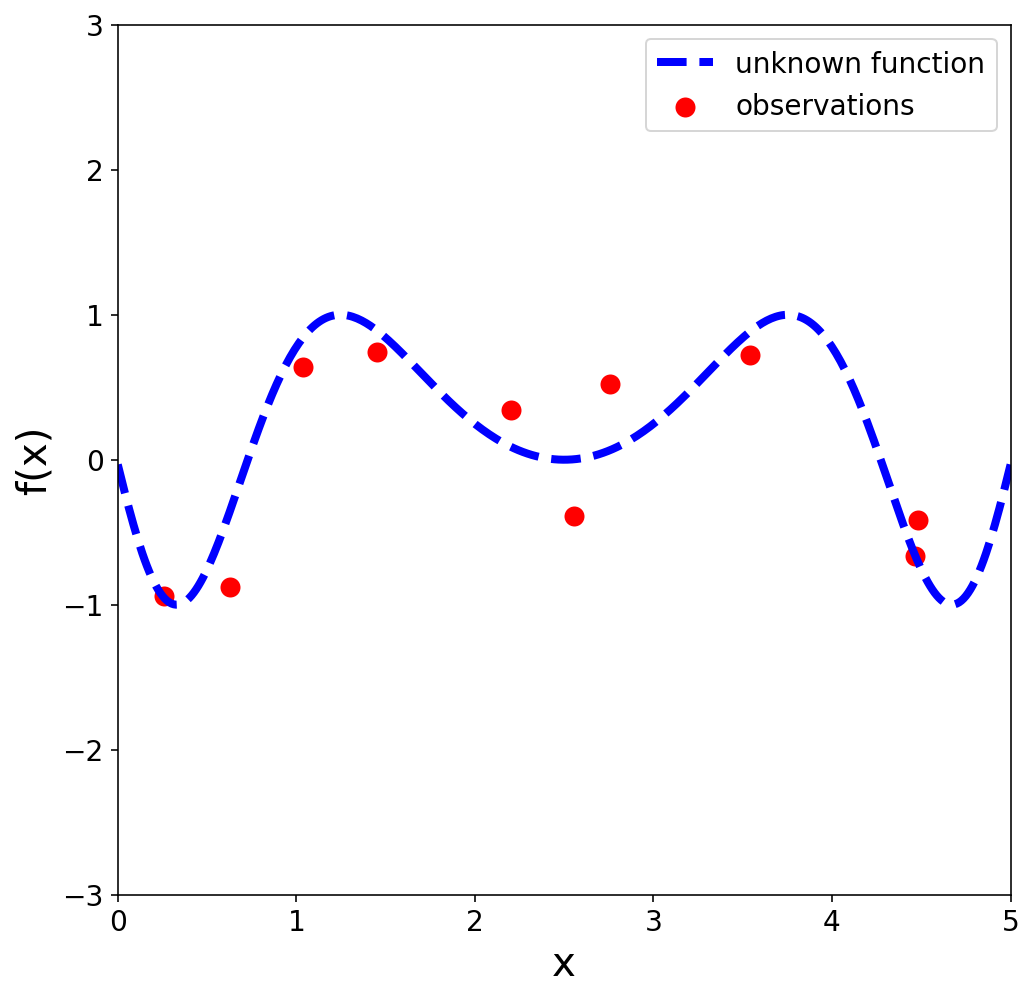

In [4]:
plt.plot(x, fx, 'b--', label='unknown function')
plt.scatter(X[:, 0], y, c='r', linewidths=0, label='observations')
plt.legend(loc='best')
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("f(x)");

---

## Gaussian processes


In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# RBF is what sklearn calls the squared exponential kernel

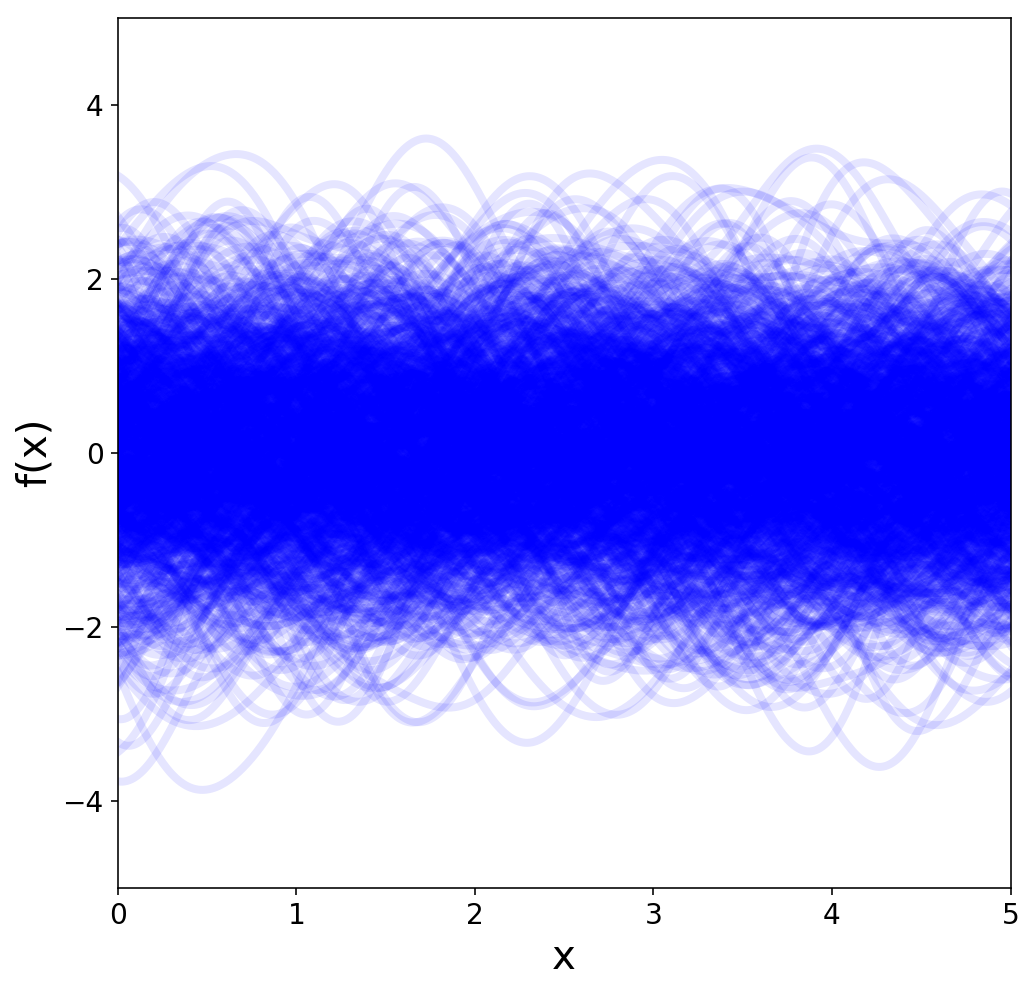

In [6]:
# we have no data yet, so this is the "prior". Why prior?
# With our choice of kernel we specify that near by points should be similar in
# function value.

# try different values here 0.1, 1, 2, 10
kernel = (1.0 * RBF(length_scale=0.5) +
          # WhiteKernel is a way to incorporate noise into your model
          WhiteKernel(noise_level=0.0000000001, noise_level_bounds=(1e-10, 1e+1)))
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_level**2)


# sample some possible functions
#y_samples = gp.sample_y(x, 5)
#plt.plot(x, y_samples)
y_samples = gp.sample_y(x, 1000)
plt.plot(x, y_samples, "b", alpha=0.1, lw=4)
plt.xlim(0, 5)
plt.ylim(-5, 5)
plt.xlabel("x")
plt.ylabel("f(x)");

0.55**2 * RBF(length_scale=0.401) + WhiteKernel(noise_level=0.158)


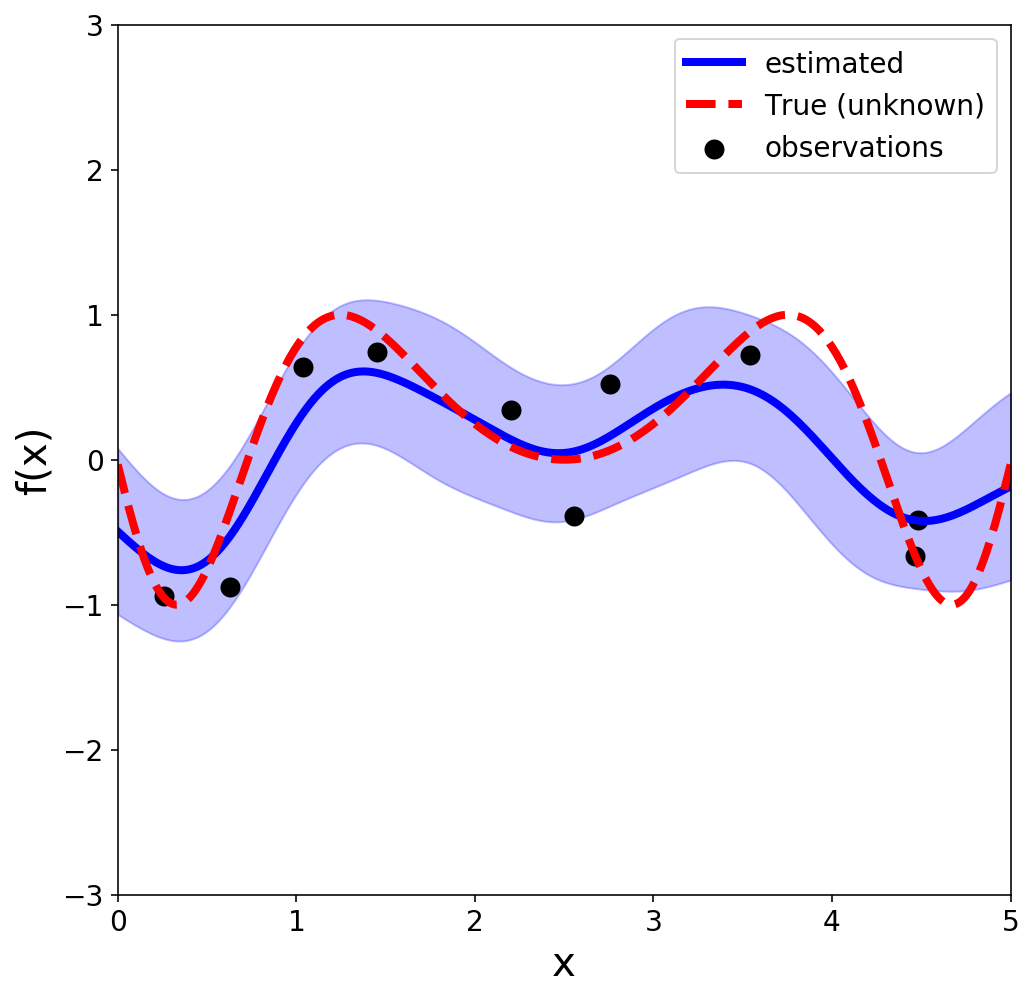

In [7]:
# Plot posterior. We now have data that our GP has fitted. There are less
# possible functions that fit the data.

# fit our GP
# attribute all the variation in the noise parameter
kernel = (1.0 * RBF(length_scale=2) +
          WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 10))
         )

# attribute all the variation to the length_scale
kernel = (1.0 * RBF(length_scale=0.5) +
          WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 10))
         )

# Goldilocks
kernel = (1.0 * RBF(length_scale=0.5, length_scale_bounds=(0.3, 2)) +
          WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 10))
         )

gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)
print(gp.kernel_)

x_ = x.reshape(-1)
y_mean, y_std = gp.predict(x, return_std=True)

plt.plot(x_, y_mean, 'b', label='estimated')
# Draw a shaded area to reflect uncertainty
plt.fill_between(x_,
                 y_mean - y_std,
                 y_mean + y_std,
                 alpha=0.25, color='b')

# Sample some possible functions
#y_samples = gp.sample_y(x, 5)
#plt.plot(x, y_samples, "b", alpha=0.5)

plt.scatter(X[:, 0], y, c='k', linewidths=0, label='observations')

plt.plot(x, fx, "r--", label="True (unknown)")

plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.legend(loc='best')
plt.ylabel("f(x)");

### Priors, posteriors and more

http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py

---

## Quantile regression with trees

In [8]:
from sklearn.ensemble import GradientBoostingRegressor


# estimate the range from 16% to 84% percentile, also known as 68% interval
alpha = 0.68 + 0.16

# one regressor per quantile that we are trying to estimate
mid = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                random_state=1)
high = GradientBoostingRegressor(loss='quantile', alpha=1-alpha,
                                 random_state=1)
low = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                random_state=1)

mid.fit(X, y)
low.fit(X, y)
high.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = mid.predict(x)
y_upper = high.predict(x)
y_lower = low.predict(x)

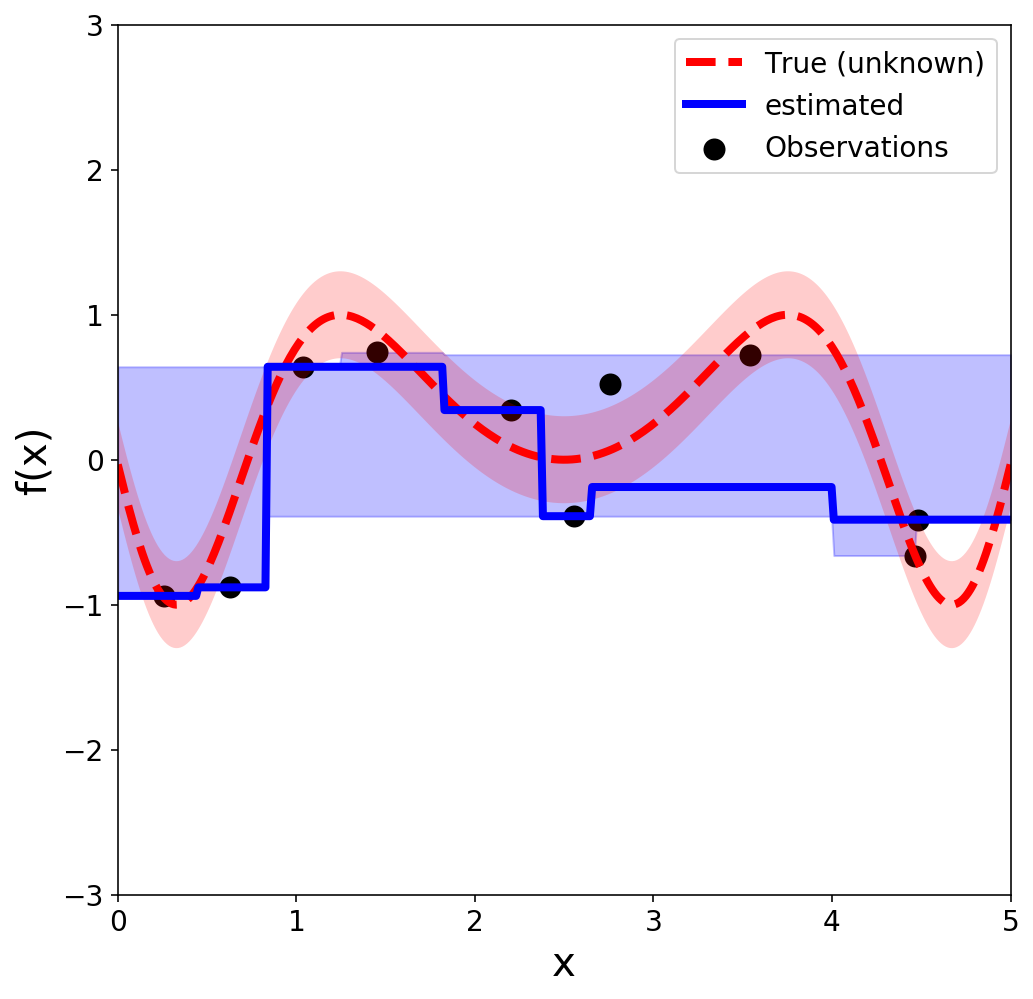

In [9]:
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - noise_level for fx_i in fx], 
                         [fx_i + noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

plt.plot(x, y_pred, 'b', label='estimated')
plt.fill_between(x_,
                 y_lower,
                 y_upper,
                 alpha=0.25, color='b')

plt.scatter(X[:, 0], y, color='k', label='Observations')

plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("f(x)");
plt.legend(loc='best');

---

## Exercise

As an exercise run the notebook again but this time with 100 points instead of 10.